# 1. Brief Introduction of Mental Rotation
A mental rotation experiment is an essential tool in psychology for examining spatial cognition. It investigates the way our minds manipulate and visualize objects. In these experiments, participants are usually **presented with pairs of objects** — images of 3D models — which may be identical or mirror images, **rotated to various degrees**. The participants must determine whether the objects are the **same or different**, emphasizing both response time and accuracy.
## 1.1 Experiment Design
The experiment unfolded as follows: each trial initiated with a 0.5-second inter-trial interval (ITI), succeeded by the presentation of a **pair of images featuring a 3D model**. These images, depicting **various rotation angles**, could originate from **a single source or two akin yet separate sources**. Participants were tasked with discerning whether the images illustrated the **same object**, in essence, determining if they were **rotated versions of each other**. Affirmative responses necessitated a right arrow key press, whereas negative responses called for a left arrow key press. The experiment employed **open-source images** that have been empirically **validated** (Ganis & Kievit, 2015). Below is an exemplar of one such image used in the study.After **24 practices with feedback**, data would be collected in **96 experiment trials**. Subjects were instructed to **respond** as **quickly** as possible while maintaining a **high rate of correctness**.

<p style="text-align:center;"> 
<img src="Pictures/Mental_Rotation_Procedure.png" alt="Mental Rotation Procedure" width="960" />
</p>

## 1.2 Work Flow
In the current Jupyter notebook, we began by merging the individual data files for each subject. We then implemented basic quality control by ensuring the correctness rate exceeded a specified threshold. Following this, we calculated the reaction times and error rates for each subject at various angles. Lastly, we visually represented this data through graphs and conducted statistical analysis to test our hypothesis. 

**Note**: Citation was attached in the last section of this notebook.

In [1]:
# Imports
from pathlib import Path
## Data, plot and statistical model
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
## Pingouin add function for pd.DataFrame
## e.g. df.rm_anova performs repeated measurement anova for df
import pingouin as pg
## Suppress future warnings
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = '10'
plt.style.use('seaborn-v0_8-pastel')

# 2. Data Preparation
Within the "Data" folder, various subfolders house data collected from different platforms. This data was consolidated into a single dataframe object. Subsequently, we **filtered the rows** pertinent to our analysis (**experiment trials**), and tallied the number of subjects contributing data from each platform.

In [2]:
from_folder = Path('Data/Mental_Rotation')
# Combine subject data to a dataframe and then add their group and id
data = []
for file in from_folder.rglob('*.csv'):
    datum = pd.read_csv(file)
    datum['sub_id'] = file.stem
    datum['group'] = file.parent.stem.split('_')[0]
    data.append(datum)

# Select experimental rows
data = (pd.concat(data)
        .query('trial_type == "Exp"')
        .drop(columns=['trial_type']))
data['angle'] = data['angle'].astype(int)

# Create a {sub_id: group} mapping
mapping = data.drop_duplicates('sub_id').set_index('sub_id')['group'].to_dict()
# The number of each group
raw_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
raw_subject_n.name = 'raw count'
print('The following illustrates the number of participants from each group:')
raw_subject_n

The following illustrates the number of participants from each group:


group
Naodao      32
Offline     34
Pavlovia    38
Name: raw count, dtype: int64

## 2.1 Brief Explanation of Data Columns
Each row represents a trial undertaken by a specific subject. The columns are defined as follows:
- **angle**: *orientation*. The rotation angle of the image during the trial, which can be one of the following values: [0, 50, 100, 150].
- **corr**: *correctness*. Indicates whether the response in the current trial was correct, denoted as 1, or incorrect, denoted as 0.
- **rt**: *response time*. The time, in seconds, taken by the subject to respond.
- **sub_id**: *subject ID*. The unique identifier for the subject participating in the trial.
- **group**: Represents the platform where the subjects participated in the experiment. The possible values are:
  - Naodao: Referring to the [Naodao Research Platform](https://www.naodao.com).
  - Pavlovia: Referring to the [Pavlovia platform](https://pavlovia.org).
  - Offline: Denoting subjects recruited at the offline lab at Beijing Normal University.


In [3]:
data

,angle,corr,rt,sub_id,group
24,150,1.0,2.7361,001,Naodao
25,50,1.0,2.0849,001,Naodao
26,150,1.0,2.4782,001,Naodao
27,50,1.0,1.1893,001,Naodao
28,150,1.0,3.0229,001,Naodao
...,...,...,...,...,...
115,0,1.0,1.3991,104,Pavlovia
116,150,0.0,1.7682,104,Pavlovia
117,0,1.0,0.6355,104,Pavlovia
118,0,1.0,0.5432,104,Pavlovia


# 3. Quality Control
We performed basic quality control on the data, excluding subjects with a **correctness rate below 25% (chance level)**. This led to the removal of one subject from the Pavlovia group, None from the Naodao or offline group.

In [4]:
corr_rate = data.groupby(['sub_id'])['corr'].mean()
corr_rate.name = 'corr_rate'
data = (data
        .merge(corr_rate.reset_index(), on='sub_id')
        .query('corr_rate >= 0.25')
        .drop(columns=['corr_rate']))
clean_subject_n = data.drop_duplicates(subset=['sub_id']).groupby('group')['sub_id'].count()
clean_subject_n = pd.DataFrame(clean_subject_n)
clean_subject_n.columns = ['after clean']
clean_subject_n['before clean'] = raw_subject_n
print('The following illustrates the number of participants from each group:')
clean_subject_n

The following illustrates the number of participants from each group:


,after clean,before clean
group,,
Naodao,32,32
Offline,34,34
Pavlovia,37,38


# 4. Measurement Calculation
As outlined earlier, mental rotation research focuses on assessing **response time and correctness rate** at different rotational angles. In the next phase of our analysis, we will determine the error rate and mean reaction time of subjects at various rotation angles. Specifically, the analysis of **response time** data will incorporate only those trials where the **responses** were **correct**. Furthermore, any trial exhibiting a reaction time exceeding **plus or minus two standard deviations from the mean** reaction time will be **excluded** from the analysis. This approach aligns with established methodologies in the literature (Ganis & Kievit, 2015).

In [5]:
# Error rate
error_rate_result = 1 - data.groupby(['sub_id', 'angle'])['corr'].mean()

# Mean Response Time (MnRT)
## Include only correct trials
rt_data = data.query('corr == 1')
## Remove data points away from mean ± 2 standard deviation
sub_mean_std = rt_data.groupby(['sub_id'])['rt'].agg(['mean', 'std'])
rt_data = rt_data.merge(sub_mean_std.reset_index())
rt_data['rt_lower'] = rt_data['mean'] - 2 * rt_data['std']
rt_data['rt_upper'] = rt_data['mean'] + 2 * rt_data['std']
rt_data = rt_data.query('(rt >= rt_lower) & (rt <= rt_upper)')
rt_result = rt_data.groupby(['sub_id', 'angle'])['rt'].mean()

# Concatenate the results
plot_data = pd.concat([error_rate_result, rt_result], axis=1)
plot_data.columns = ['ER', 'MnRT']
plot_data = plot_data.reset_index()
plot_data['group'] = plot_data['sub_id'].map(mapping)
plot_data['angle'] = plot_data['angle'].astype(int)
plot_data.to_csv('Data/Mental_Rotation.csv', index=False)

## 4.1 Brief Explanation of Data Columns
In addition to the variables introduced in section 2.1, we have incorporated the following:
- **ER**: *error rate*. The error rate for each subject, assessed at different perspectives.
- **MnRT**: *mean response time*. The average response time for each subject, measured at various angles.

In [6]:
plot_data.query('angle==150').sort_values(by=['ER'], ascending=False)

,sub_id,angle,ER,MnRT,group
307,077,150,0.500000,3.407000,Pavlovia
271,068,150,0.458333,0.109731,Pavlovia
163,041,150,0.458333,4.036330,Offline
91,023,150,0.416667,2.824931,Naodao
207,052,150,0.416667,3.261182,Offline
...,...,...,...,...,...
187,047,150,0.041667,2.706781,Offline
195,049,150,0.041667,2.031374,Offline
199,050,150,0.041667,3.132299,Offline
151,038,150,0.000000,3.155353,Offline


# 4. Plots
Visualizations can enhance the comprehension of the results. These images can be found in the "Pictures" folder.

C:\Users\Chen\AppData\Roaming\Python\Python38\site-packages\outdated\utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


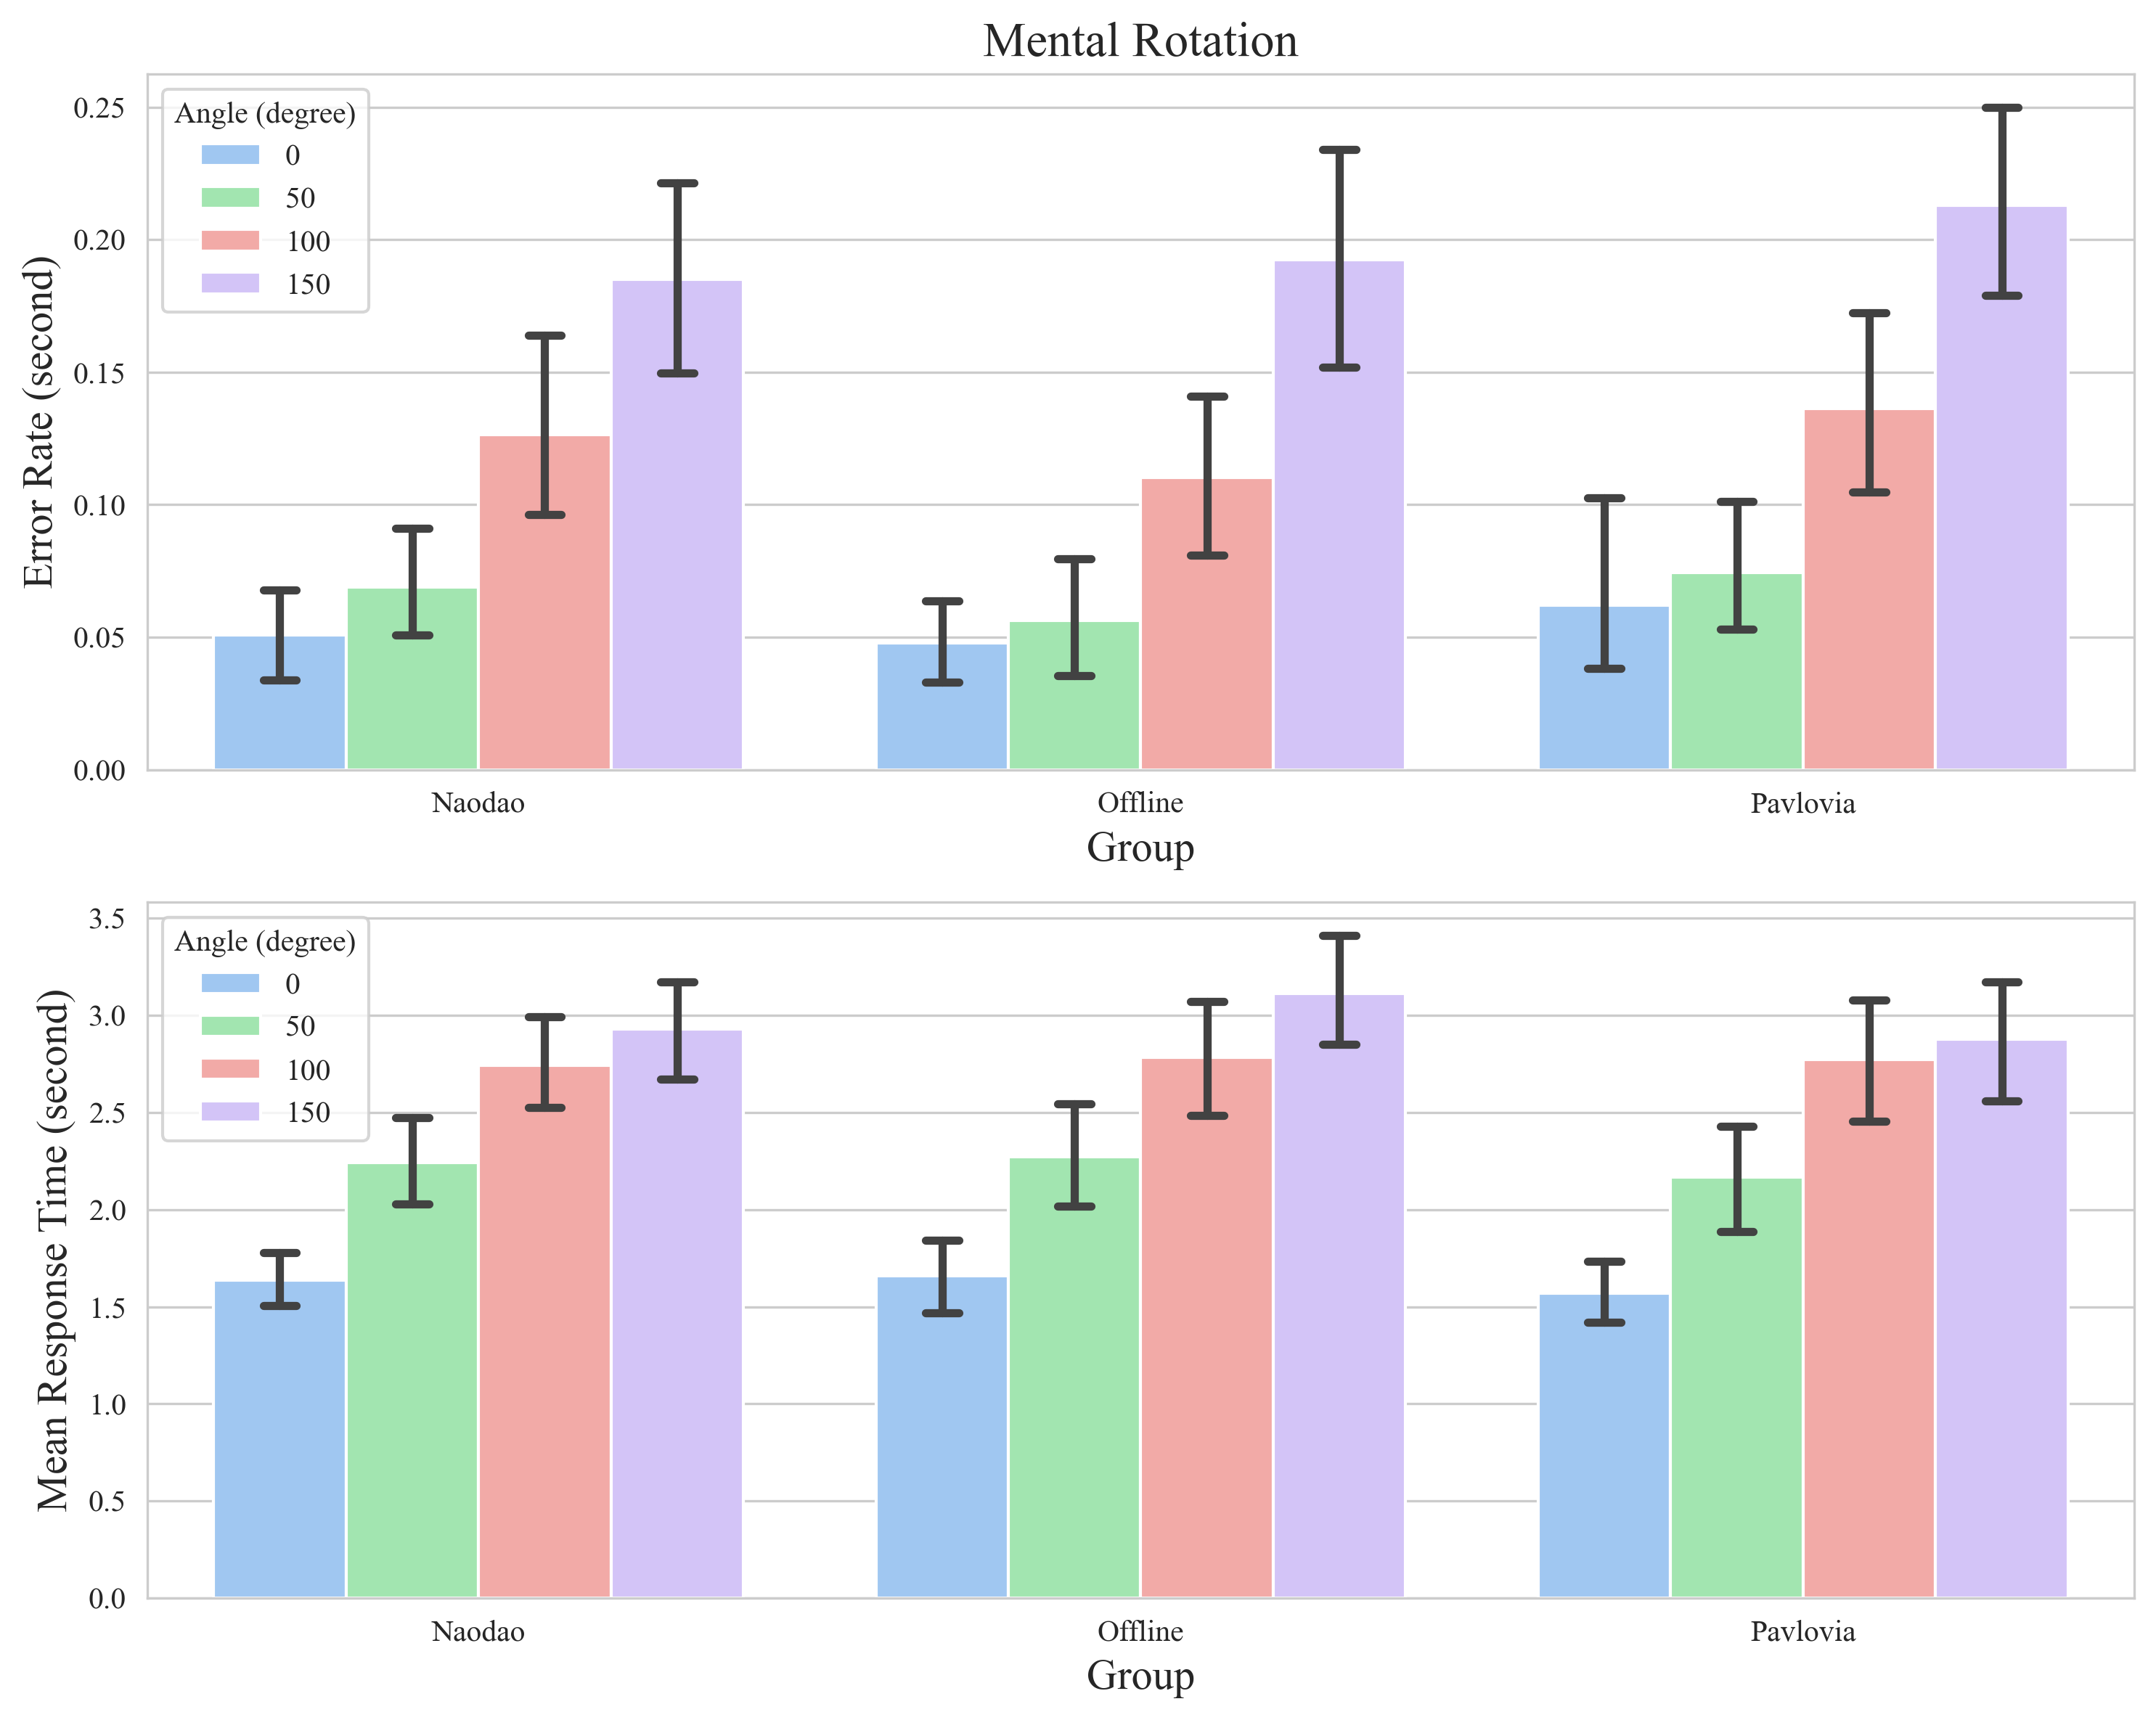

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), dpi=300)
ax = axes[0]
sns.barplot(data=plot_data, x='group', y='ER', hue='angle', capsize=0.05, ax=ax)
ax.set_ylabel('Error Rate (second)', fontsize=14)
ax.set_xlabel('Group', fontsize=14)
ax.set_title('Mental Rotation')
ax.title.set_size(16)
ax.legend().set_title('Angle (degree)')

ax = axes[1]
sns.barplot(data=plot_data, x='group', y='MnRT', hue='angle', capsize=0.05, ax=ax)
ax.set_ylabel('Mean Response Time (second)', fontsize=14)
ax.set_xlabel('Group', fontsize=14)
ax.legend().set_title('Angle (degree)')

plt.tight_layout()
fig.savefig('Pictures/Mental_Rotation_Result.png')

# 5. Statistical Analysis
Mental rotation typically induces a linear augmentation in both error rate and reaction time as the rotation angle increases from 0 to 180 degrees. In this section, we utilized ANOVA to carry out the pertinent analyses.

## 5.1 Effect Replication
Initially, we sought to confirm the recurrence of the classical effect within each group. We employed a repeated measures ANOVA (RM-ANOVA) to accomplish this. Interpretation of each column in the data set as detailed below:

- **ddof1**: Degrees of freedom (numerator)
- **ddof2**: Degrees of freedom (denominator)
- **F**: F-value
- **p-unc**: Uncorrected p-value
- **np2**: Partial eta-square effect size
- **ng2**: Generalized eta-square effect size

These definitions are derived from the documentation of the Pingouin Python package, further details of which can be found at [pg.rm_anova](https://pingouin-stats.org/build/html/generated/pingouin.rm_anova.html#pingouin.rm_anova).

Our findings **affirm the replication of the mental rotation effect** across distinct groups(*p*s < .00001). Moreover, the observed **effect sizes** were notably **consistent across groups**, aligning substantially with documented literature values. For simplicity, we have depicted the results utilizing the **partial eta square ($ \eta^2_p $)**  reported in the cited literature (Ganis & Kievit, 2015). Regarding mean response time, the literature cites an effect size of **0.82**, while our data exhibits a range from **0.68 to 0.84**. In terms of error rate, the documented effect size is **0.75**, contrasted with our data span of **0.48 to 0.60**. These minor variances could potentially originate from sampling disparities including racial, age, experiment design, material differences, among others.

In [8]:
result_list = []
for measure in ['MnRT', 'ER']:
    for group in plot_data['group'].unique():
        this_data = plot_data.query(f'group == "{group}"')
        # Perform ANOVA analysis and the select columns (for simplicity)
        result = this_data.rm_anova(dv=measure, subject='sub_id', within='angle', effsize='np2').round(5)
        result = result[['ddof1', 'ddof2', 'F', 'p-unc', 'np2']]
        result.insert(0, 'group', group)
        result.insert(1, 'measure', measure)
        result_list.append(result)
pd.concat(result_list)

,group,measure,ddof1,ddof2,F,p-unc,np2
0,Naodao,MnRT,3,93,142.07361,0.0,0.82089
0,Offline,MnRT,3,99,146.16029,0.0,0.81581
0,Pavlovia,MnRT,3,108,141.02944,0.0,0.79664
0,Naodao,ER,3,93,23.92336,0.0,0.43558
0,Offline,ER,3,99,34.93885,0.0,0.51427
0,Pavlovia,ER,3,108,41.61372,0.0,0.53616


It's crucial to underscore that the effect sizes delineated here **don't conclusively signify the strengths or weaknesses of various platforms**. For an instance, in the previous analysis, it appeared that the Naodao research platform exhibited the lowest effect size in the **error rate** analysis. Yet, referring to the guidelines from a highly cited article (Lakens, 2013) — which has amassed 7,556 citations as of the creation of this document — it is advocated to:
>When reporting effect sizes for ANOVAs it is **recommended** to report **generalized eta squared** instead of (or in addition to) partial eta squared. 
> -- <cite>Lakens, 2013</cite>

Adhering to this recommendation and utilizing the more frequently applied $ \eta^2_g $ in repeated measures ANOVA, we find that **Naodao could boast the second-highest effect size**.

In [9]:
result_list = []
for measure in ['MnRT', 'ER']:
    for group in plot_data['group'].unique():
        this_data = plot_data.query(f'group == "{group}"')
        # Perform ANOVA analysis and the select columns (for simplicity)
        result = this_data.rm_anova(dv=measure, subject='sub_id', within='angle', effsize='ng2').round(5)
        result = result[['ddof1', 'ddof2', 'F', 'p-unc', 'ng2']]
        result.insert(0, 'group', group)
        result.insert(1, 'measure', measure)
        result_list.append(result)
pd.concat(result_list)

,group,measure,ddof1,ddof2,F,p-unc,ng2
0,Naodao,MnRT,3,93,142.07361,0.0,0.39883
0,Offline,MnRT,3,99,146.16029,0.0,0.33708
0,Pavlovia,MnRT,3,108,141.02944,0.0,0.28090
0,Naodao,ER,3,93,23.92336,0.0,0.29451
0,Offline,ER,3,99,34.93885,0.0,0.31612
0,Pavlovia,ER,3,108,41.61372,0.0,0.26942


## 5.2 Comparison Between Groups
Next, we aim to identify any significant disparities between the different groups by utilizing mixed ANOVA. In this approach, the angle served as the within-subject independent variable, while the group designation functioned as the between-subject independent variable.

The outcomes indicate that **neither a **main effect** of group **nor an interaction effect** between group and angle is present (*p*s > .36). Even if such effects were discernible, they would be considered minor, registering **effect sizes within the range of 0.002 to 0.009**, according to Cohen's 1998 classification of effect sizes (Cohen, 2013).

In [10]:
# Measure = Error Rate
result = plot_data.mixed_anova(dv='ER', subject='sub_id', within='angle', between='group', effsize='ng2').round(5)
result[['Source', 'DF1', 'DF2', 'F', 'p-unc', 'ng2']]

,Source,DF1,DF2,F,p-unc,ng2
0,group,2,100,0.75224,0.47396,0.00877
1,angle,3,300,98.82488,0.00000,0.28926
2,Interaction,6,300,0.29130,0.94085,0.00239


In [11]:
# Measure = Mean Response Time
result = plot_data.mixed_anova(dv='MnRT', subject='sub_id', within='angle', between='group', effsize='ng2').round(5)
result[['Source', 'DF1', 'DF2', 'F', 'p-unc', 'ng2']]

,Source,DF1,DF2,F,p-unc,ng2
0,group,2,100,0.21241,0.80900,0.00375
1,angle,3,300,424.87667,0.00000,0.32691
2,Interaction,6,300,1.10378,0.36001,0.00252


# References 
- Cohen, J. (2013). Statistical power analysis for the behavioral sciences. Academic press.
- Ganis, G., & Kievit, R. (2015). A new set of three-dimensional shapes for investigating mental rotation processes: validation data and stimulus set. Journal of Open Psychology Data Files in this Item Files Size Format View 13-116-2-PB. pdf 567.5 Kb PDF View/Open.
- Lakens, D. (2013). Calculating and reporting effect sizes to facilitate cumulative science: a practical primer for t-tests and ANOVAs. Frontiers in psychology, 4, 863.